# Practical Class 5 - Modelling of DACs at gate (transistor) level

In [1]:
# mathematical computing
import numpy as np
import scipy as sp
from scipy import signal # to generate the noise signal
import seaborn as sns # to observe the noise signal's histogram
from numpy.random import uniform, normal # random numbers fitted into a uniform distribution
# plotting
import matplotlib.pyplot as plt
# import the models and utilities functions
from utils import ideal_dac, ideal_adc, nonideal_adc, dec2bin, bin2dec

%matplotlib inline

## Modelling of a Thermometer Code DAC


<p align="center">
    <img src="../docs/imgs/thermometer_dac.png" alt="thermometer-dac" height="350">
</p>

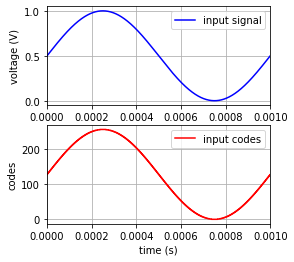

In [2]:
# set up the DAC parameters
vref = 1 # V
nbits = 8 # number of bits
vlsb = vref / (2**nbits) # V
# number of simulation points
Np = 1e6
# define the time base
Fs = 1e9 # Hz
Ts = 1/Fs # s
tD = np.arange(0,Np)*Ts; # (0:Np-1) == np.arange(0,Np)
# setup the input codes
A1 = vref/2
f1 = 1e3 # Hz
ph1 = 0 # rad
ofst = 0.0
si = A1*np.sin(2*np.pi*f1*tD + ph1) + ofst + vref/2
# get the codes from the ideal DAC
incodes = np.round(si/vlsb).astype(int)
# represent the input signal and codes
fig, ax = plt.subplots(2,1, figsize=(4,4))
ax[0].plot(tD, si, 'b', label='input signal')
ax[0].set_xlabel('time (s)')
ax[0].set_ylabel('voltage (V)')
ax[0].legend()
ax[1].plot(tD, incodes, 'r', label='input codes')
ax[1].set_xlabel('time (s)')
ax[1].set_ylabel('codes')
ax[1].legend()
ax[0].set_xlim([0, 1/(f1)])
ax[1].set_xlim([0, 1/(f1)])
ax[1].grid(); ax[0].grid()

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'resistor values distribution')

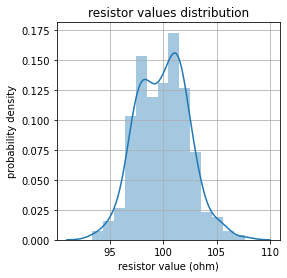

In [3]:
# model the resistor ladder
ru = 100 # ohm - unit resistance
R = np.ones(2**nbits)*ru
# resistance mismatch in ohm, following a normal distribution
u_err = 0.0
u_std = 0.15 # 15% of the unit resistance for a semiconductor resistor
r_err = normal(u_err, u_std**2, 2**nbits)
R = R + r_err*ru
# show the resistor values
fig, ax = plt.subplots(1,1, figsize=(4,4))
sns.distplot(R, ax=ax)
ax.set_xlabel('resistor value (ohm)')
ax.set_ylabel('probability density')
ax.grid()
ax.set_title('resistor values distribution')

Text(0.5, 1.0, 'DAC transfer function')

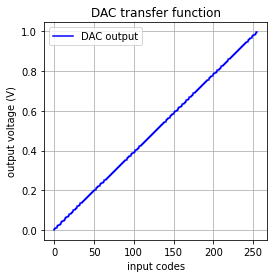

In [4]:
# compute the DAC output voltage for each input code, considering the errors in the resistors
codes = np.arange(2**nbits)
vout_nonideal = np.array([np.sum(R[:code])/np.sum(R) for code in codes])
# observe the DAC transfer function
fig, ax = plt.subplots(1,1, figsize=(4,4))
ax.step(codes,vout_nonideal, 'b', label='DAC output')
ax.set_xlabel('input codes')
ax.set_ylabel('output voltage (V)')
ax.legend()
ax.grid()
ax.set_title('DAC transfer function')

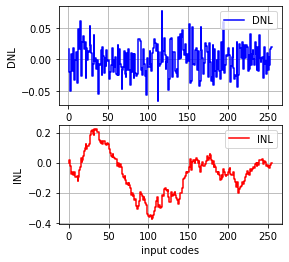

In [5]:
# compute the DNL and INL of the DAC featuring the resistor mismatch
vlsb_measured = (vout_nonideal[2**nbits - 1] - vout_nonideal[0])/(2**nbits - 1)
dnl = np.diff(vout_nonideal)/vlsb_measured - 1
inl = np.array([0] + np.cumsum(dnl).tolist())
assert len(dnl) == 2**nbits - 1
assert len(inl) == 2**nbits
# plot the DNL and INL
fig, ax = plt.subplots(2,1, figsize=(4,4))
ax[0].step(codes[1:], dnl, 'b', label='DNL')
ax[0].set_xlabel('input codes')
ax[0].set_ylabel('DNL')
ax[0].legend()
ax[0].grid()
ax[1].step(codes, inl, 'r', label='INL')
ax[1].set_xlabel('input codes')
ax[1].set_ylabel('INL')
ax[1].legend()
ax[1].grid()

As it is possible to observe, the DAC is sensitive to resistor mismatch, severely impacting its INL, which translates in vlasb errors when producing the output voltage. Let us now compute the effective resolution of 100 thermometer ladder DAC converters for a random resistor mismatch following a normal distribution, and check the histogram of the effective resolution of the DACs. This is a very common analysis to check the impact of device mismatch on the performance of a converter circuit.

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'DAC resolution distribution against resistor mismatch')

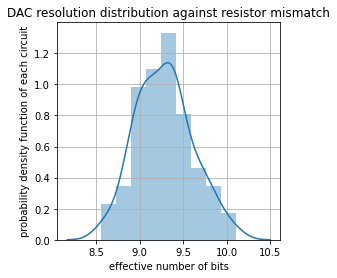

In [6]:
# generate several ladder circuits, with random resistance wheights every time, and observe the histogram of 
# the resolution of the DAC
ncircuits = 100
dac_res = [] # measure the effective resolution for each of the circuits
# resistance mismatch in ohm, following a normal distribution
u_err = 0.0
u_std = 0.15 # 15% of the unit resistance for a semiconductor resistor
for circ in range(ncircuits):
    R = np.ones(2**nbits)*ru
    r_err = normal(u_err, u_std**2, 2**nbits)
    R = R + r_err*ru
    codes = np.arange(2**nbits)
    vout_nonideal = np.array([np.sum(R[:code])/np.sum(R) for code in codes])
    vlsb_measured = (vout_nonideal[2**nbits - 1] - vout_nonideal[0])/(2**nbits - 1)
    dnl = np.diff(vout_nonideal)/vlsb_measured - 1
    inl = np.array([0] + np.cumsum(dnl).tolist())
    # compute the effective number of bits of the DAC using the INL (once the lost bits can be compute by the 
    # difference between the minimum and maximum value of the INL)
    dac_linearity = nbits - np.log2(np.max(inl) - np.min(inl))
    dac_res.append(dac_linearity)
# plot the histogram of the effective number of bits of the DAC
fig, ax = plt.subplots(1,1, figsize=(4,4))
sns.distplot(dac_res, ax=ax)
ax.set_xlabel('effective number of bits')
ax.set_ylabel('probability density function of each circuit')
ax.grid()
ax.set_title('DAC resolution distribution against resistor mismatch')

Let us now consider the dynamic operation of the DAC. Let us assume that at the DAC's output voltage is charging a parasitic capacitor of 0.1 pF, and the DAC is clocked at 1 MHz. Naturally, due to the output node pole defined by its RC time constant, the output voltage will not change instantaneously, but will follow a step response. Three main questions arise:
- 1 - How long does it take to charge the output capacitance to 95% of the final value of the output voltage?
- 2 - What impact does the unitary resistances of the DAC have on the output voltage step response?
- 3 - What impact do the switches have on the output voltage step response?
- 
Let us answer those questions in this section.

The settling error can be computed through:
$$
\begin{align}
\epsilon_{S} &= \frac{V^*_{out} - V_{out}}{V_{out}} = e^{-\frac{T_{CLK}}{\tau}} \\
\end{align}
$$

where $V_{out} = V_{REF}\frac{R2}{R2 + R1}$ is the ideal output voltage at the end of the half-clock period, and $V^*_{out}(t) = V_{REF}\frac{R2}{R2 + R1}(1-e^{-\frac{t}{\tau}})$ is the actual observed final output voltage. The RC time constant of the output node is given by:
$$
\begin{align}
\tau &= (C_L + C_P)*( R1 // R2 + R_{SW}) \hspace{4pt} \text{(s)}
\end{align}
$$

where $C_L$ is the load capacitance, $C_P$ is the node parasitic capacitance, $R1$ and $R2$ are the top and bottom equivalent resistances of the DAC ladder, and $R_{SW}$ is the switch ON resistance.

/var/folders/vv/xctyh4bd2td6k2w_gvh_t2vr0000gn/T/ipykernel_76131/640369409.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tD/1e-9)


(0.0, 1e-08)

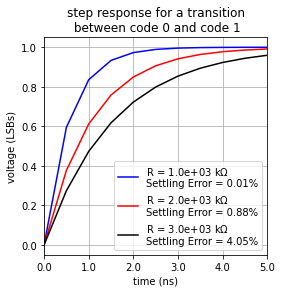

In [7]:
# plot the ideal step response
vo = lambda t_, vr_, r1_, r2_, tau_: vr_*r2_/(r1_+r2_)*(1 - np.exp((-t_/tau_)))
# compute the step respose for a transition between code 0 and code 1
fig, ax = plt.subplots(1,1, figsize=(4,4))
CL = 1e-12 # F - load capacitance
ru = 1e3 # ohm - unit resistance
num_rus = 3
rus = np.arange(1, num_rus+1)*ru
r_sw = 100 # ohm - switch resistance
cp_sw = 0.01*CL # F - switch capacitance
fclk = 100e6 # 100 MHz - clock frequency
colors = ['b', 'r', 'k', 'c', 'm', 'y', 'g']
for ru, color in zip(rus, colors):
    R = np.ones(2**nbits)*ru
    assert len(R) == 2**nbits
    req1 = sum(R[:-1]) # equivalent resistance of the top of the ladder for code 0
    req2 = R[-1] # equivalent resistance of the bottom of the ladder for code 1
    tclk = 1/fclk # s - clock period -> maximum settling time
    tauu = (CL + cp_sw)*((req1*req2)/(req1+req2) + r_sw) # tau ~= (CL + Cp)*( R1//R2 + Rsw )
    vout_t = vo(tD, vref, req1, req2, tauu)
    # compute stelling error
    err_set = np.exp(-tclk/tauu) # err _settling = [(vout - vout_ideal)/vout_ideal] = e^(-tclk/tau)
    err_set_pct = err_set*100
    #print('tau = {:.2e} s'.format(tauu))
    #print("tclk = {:.2e} s".format(tclk))
    #print("tclk/tau = {:.2f}".format(tclk/tauu))
    #print("tclk/Ts = {:.2f}".format(tclk/Ts))
    ax.plot(tD, vout_t/vlsb, color, label='R = {:.1e} k'.format(ru)+r'$\Omega$'\
        + '\nSettling Error = {:.2f}%'.format(err_set_pct))
ax.set_xlabel('time (ns)')
ax.set_xticklabels(tD/1e-9)
ax.set_ylabel('voltage (LSBs)')
ax.grid()
ax.legend()
ax.set_title('step response for a transition\n between code 0 and code 1')
ax.set_xlim(0, tclk)

Text(0.5, 1.0, 'DAC Output RC Delay vs. Input Code Transistion')

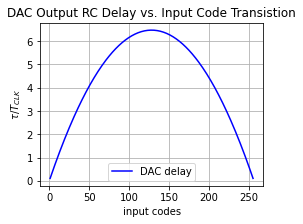

In [8]:
# observe the delay of the DAC agains the code transition
codes = np.arange(2**nbits)
ru = 1e3 # ohm - unit resistance
R = np.ones(2**nbits)*ru
tauu = np.array([
    (CL+cp_sw)*((np.sum(R[:code])*np.sum(R[code:]))/(np.sum(R[:code])+np.sum(R[code:])) + r_sw) for code in codes[1:]
])
fig, ax = plt.subplots(1,1, figsize=(4,3))
ax.plot(codes[1:], tauu/tclk, 'b', label='DAC delay')
ax.set_xlabel('input codes')
ax.set_ylabel(r'$\tau / T_{CLK}$')
ax.legend()
ax.grid()
ax.set_title('DAC Output RC Delay vs. Input Code Transistion')

In [9]:
# compute the static power dissipation of the DAC
ru = 1e3 # ohm - unit resistance
R = np.ones(2**nbits)*ru
PD = (vref**2)/(len(R)*ru) # W - static power dissipation of the DAC
print('PD = {:.2f} uW'.format(PD/1e-6))


PD = 3.91 uW


One conclusion that we can retrieve from the previous analysis is that in order to reduce the overall delay of the DAC, we should reduce the RC time constant of the output node by reducing the unitary resistance of the unit resistor of the ladder. However, the lower the unitary resistance, the higher will be the mismatch sensitivity of the DAC, as well as the total static dissipated power of the thermometer ladder DAC. 

This observation holds true in general, for all DAC and ADC architectures. The total dissipated power of converters will innevitably be higher when aiming for a converters that present a lower settling error and operate at faster conversion steps.